In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim import corpora
from gensim.models import LdaModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv('X_clean.csv')

In [3]:
def prepare_for_lda(df):
    df['cleaned_title_split'] = df['cleaned_title'].apply(lambda x: x.split() if isinstance(x, str) else x)
    dictionary = corpora.Dictionary(df['cleaned_title_split'])
    corpus = [dictionary.doc2bow(text) for text in df['cleaned_title_split']]
    return dictionary, corpus

In [4]:
dictionary, corpus = prepare_for_lda(df)

In [12]:
lda_model = LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

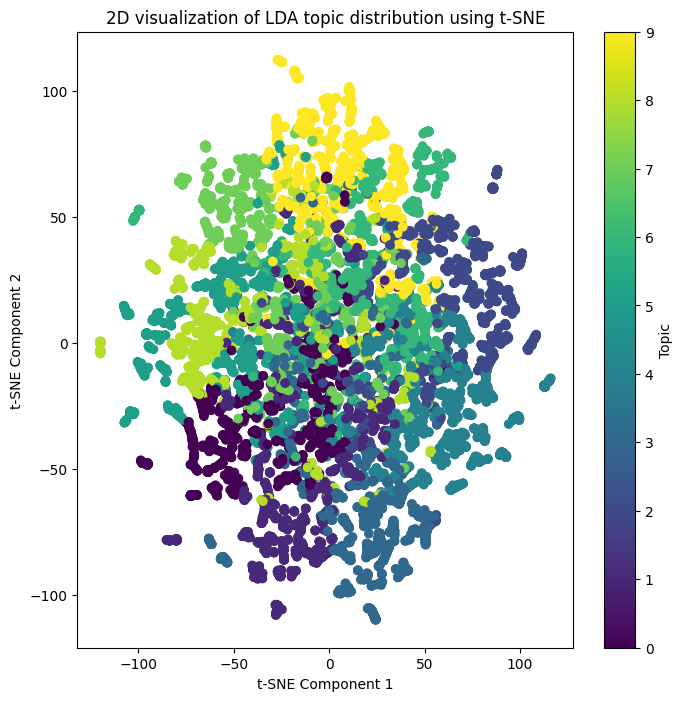

In [17]:
doc_topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]
topic_vectors = np.zeros((len(doc_topic_distributions), 10))  # 10 topics
for i, doc in enumerate(doc_topic_distributions):
    for topic_id, prob in doc:
        topic_vectors[i, topic_id] = prob
tsne_model = TSNE(n_components=2, random_state=42)
tsne_values = tsne_model.fit_transform(topic_vectors)
plt.figure(figsize=(8, 8))
plt.scatter(tsne_values[:, 0], tsne_values[:, 1], c=np.argmax(topic_vectors, axis=1), cmap='viridis')
plt.colorbar(label='Topic')
plt.title('2D visualization of LDA topic distribution using t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


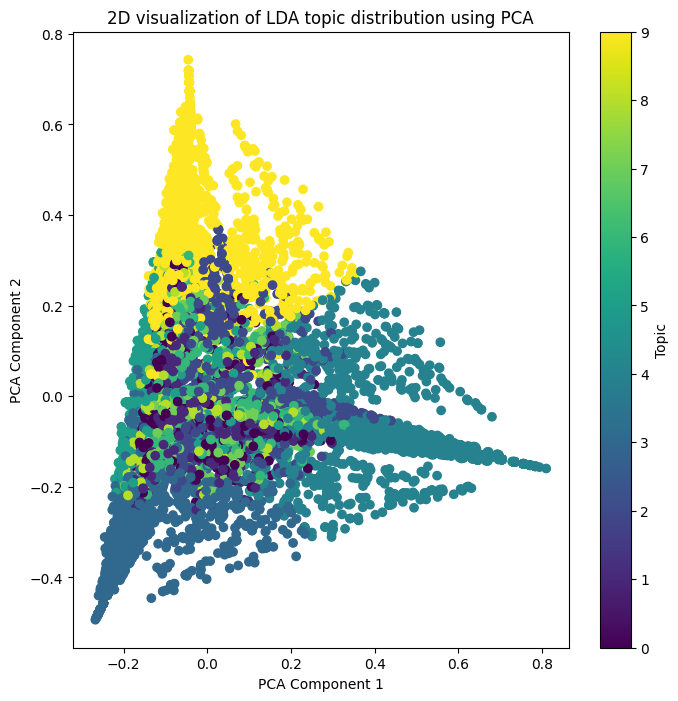

In [18]:
pca_model = PCA(n_components=2)
pca_values = pca_model.fit_transform(topic_vectors)

# Prepare the 2D plot using PCA
plt.figure(figsize=(8, 8))
plt.scatter(pca_values[:, 0], pca_values[:, 1], c=np.argmax(topic_vectors, axis=1), cmap='viridis')
plt.colorbar(label='Topic')
plt.title('2D visualization of LDA topic distribution using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Display the plot
plt.show()